In [0]:
## Run before using notebook
!pip install tensorflow==1.14.0

### Introduction
* We will be using a neural network to have it predict the next amino acid in the sequence
* We will first train a vanilla RNN that takes in a certain sequence of amino acids and predict the next one. We will train this to completion, using a sliding window of a certin length
* Once trained, have it create a certain amino acid by feeding a a truncated sequence
* Test to to have it complete
* Use protein similarity matrix to see the differences 

### Load in proteins csv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
proteins = pd.read_csv("proteins_cleaned.csv")

In [3]:
proteins.head()

,Unnamed: 0,index,structureId,chainId,sequence,residueCount,macromoleculeType,classification,experimentalTechnique,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,num_residues
0,0,4,101M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,154
1,1,7,102L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAAKSE...,165,Protein,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,1.74,18926.61,NaN,NaN,2.75,55.28,NaN,NaN,1993.0,165
2,2,8,102M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,1.84,18010.64,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,154
3,3,11,103L,A,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNSLDAAK...,167,Protein,HYDROLASE(O-GLYCOSYL),X-RAY DIFFRACTION,1.90,19092.72,NaN,NaN,2.70,54.46,NaN,NaN,1993.0,167
4,4,12,103M,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...,154,Protein,OXYGEN TRANSPORT,X-RAY DIFFRACTION,2.07,18093.78,NaN,NaN,3.09,60.30,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",9.0,1999.0,154


In [4]:
#grab only the necessary columns to save on space
proteins = proteins[['residueCount','sequence','macromoleculeType','classification']]

In [5]:
proteins.shape

(346321, 4)

Because there are so many proteins, let's see if we can do this with just one class of proteins first. Test the efficacy of the model by and see if it can recreate a protein by inputing a certain length of amino acids
* Don't chose a class of proteins with too many samples, it takes up too much memory
* Scale down 10 times
* Chose class with around 4000 or so samples 

In [6]:
proteins['classification'].value_counts()[proteins['classification'].value_counts() < 5000]

LIGASE                             4964
MEMBRANE PROTEIN                   4891
PROTEIN BINDING                    4884
STRUCTURAL PROTEIN                 4335
CHAPERONE                          4156
                                   ... 
PROTEIN BINDING,METAL TRANSPORT       1
SIGNALING PROTEIN, TRANSLATION        1
INTEIN                                1
OXYGEN TRANSPORT,OXIDOREDUCTASE       1
LIGASE/Reaction intermediate          1
Name: classification, Length: 4456, dtype: int64

In [7]:
#subset HYDROLASE
proteins = proteins[proteins['classification'] == 'MEMBRANE PROTEIN']

In [8]:
proteins.shape

(4891, 4)

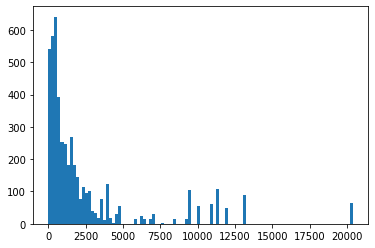

In [9]:
plt.hist(proteins['residueCount'],bins=100)
plt.show()

In [10]:
proteins['residueCount'].min()

9

In [11]:
sum(proteins['residueCount'] > 70)

4754

Starting off, we will set the sliding window to 70 first, we need to subset the dataset so that we only get proteins greater than length 70

In [12]:
proteins = proteins[proteins['residueCount'] > 70]
proteins.shape

(4754, 4)

In [13]:
sum(proteins['residueCount'] > 8192)

558

### Vectorization

* For each protein, create a window of length 70.
* Have it predict 70 + 1'th acid
* Slide window across entire length of amino acid
* return letters
* Define this as a function
* Start with letters first then pull vectorize with dictionary update
* Use sklearn count vectorizer than apply rolling window to it
* Start with 512 as the max length, will lose some stuff though


In [15]:
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# maximum length of sequence, everything afterwards is discarded!
max_length = 256

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(proteins['sequence'])
#represent input data as word rank number sequences
X = tokenizer.texts_to_sequences(proteins['sequence'])
X = sequence.pad_sequences(X, maxlen=max_length,padding='post')

In [16]:
X.shape

(4754, 256)

In [17]:
max_len = 70
#skip over 4
#step = 4

In [18]:
X[0]

array([17,  8, 13,  1, 13, 17,  9,  1,  1, 15, 17,  2,  2,  2,  4, 17, 17,
        3,  1,  2,  2,  6,  3,  2,  2,  6,  3,  6,  3,  6,  1,  3,  3, 10,
       11,  1,  8,  3,  2,  2, 12, 16, 14,  9,  1,  6, 14,  1,  1, 12,  7,
       16, 11, 11,  6,  4, 17,  3,  1,  4,  9,  2,  6, 14, 17,  6,  2,  4,
        3,  1,  3,  1, 15,  4, 17, 11,  2,  4,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [19]:
#check sparsity
sum(sum(X == 0)) / (46235*8192)

0.000725530915432032

In [20]:
X[0,0:70]

array([17,  8, 13,  1, 13, 17,  9,  1,  1, 15, 17,  2,  2,  2,  4, 17, 17,
        3,  1,  2,  2,  6,  3,  2,  2,  6,  3,  6,  3,  6,  1,  3,  3, 10,
       11,  1,  8,  3,  2,  2, 12, 16, 14,  9,  1,  6, 14,  1,  1, 12,  7,
       16, 11, 11,  6,  4, 17,  3,  1,  4,  9,  2,  6, 14, 17,  6,  2,  4,
        3,  1], dtype=int32)

### Creating  X and Y
* will have 3 dimensions (len(all_samples), max_len, len(boolean_chars))
* Or each element in the tensor X will be a matrix, each matrix will have the number of columns equaling the number of times the window fits into the sequence, and the number of rows will be equal to the len of the tokenzier, and the position in the row will indicate what the amino acid is
* the Y will be the sequence after that window again as a boolen

In [21]:
tokenizer.word_index

{'l': 1,
 'a': 2,
 'g': 3,
 'v': 4,
 's': 5,
 'i': 6,
 't': 7,
 'e': 8,
 'd': 9,
 'k': 10,
 'f': 11,
 'r': 12,
 'n': 13,
 'p': 14,
 'y': 15,
 'q': 16,
 'm': 17,
 'h': 18,
 'w': 19,
 'x': 20,
 'c': 21}

In [22]:
len(tokenizer.word_index)

21

Create a matrix first of one X and a vector of 1 y

In [23]:
test = X[0,:]
test

array([17,  8, 13,  1, 13, 17,  9,  1,  1, 15, 17,  2,  2,  2,  4, 17, 17,
        3,  1,  2,  2,  6,  3,  2,  2,  6,  3,  6,  3,  6,  1,  3,  3, 10,
       11,  1,  8,  3,  2,  2, 12, 16, 14,  9,  1,  6, 14,  1,  1, 12,  7,
       16, 11, 11,  6,  4, 17,  3,  1,  4,  9,  2,  6, 14, 17,  6,  2,  4,
        3,  1,  3,  1, 15,  4, 17, 11,  2,  4,  2,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [24]:
#a sample will have three dimensions
#dim 1 is the total number of windows possible across the sequence, the ith window
#dim 2 is the actual lenght of the window, 70
#dim 3 if the boolean index according to the tokenize
#each ith window will be a matrix

#for y will have one dimensions
#dim 1 is the next character after the ith window

#so a matrix will map to a vector
xs_one_sample = np.zeros((len(test)-max_len,max_len,len(tokenizer.word_index)),dtype=np.bool)
ys_to_array = np.zeros((len(test)-max_len,len(tokenizer.word_index)),dtype=np.bool)
for i in range(0,len(test)-max_len):
  #pull window
  window = test[i:max_len]
  #update xs_one_sample matrices and vectors
  for j in range(0,len(window)-1):
    xs_one_sample[i,j,window[j]-1] = 1
  #pull next char 
  next_char = test[max_len+i]
  ys_to_array[i,next_char-1] = 1

In [25]:
xs_one_sample.shape, ys_to_array.shape

((186, 70, 21), (186, 21))

Check sums to see if there were inputs

In [26]:
np.sum(ys_to_array)

186

In [27]:
ys_to_array[0]

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [28]:
np.sum(xs_one_sample[0,:,:])

69

Wrap into a neat function to apply over all samples

In [29]:
def create_x_y(sample,window_size,dict_amino_acids):
  xs_one_sample = np.zeros((len(sample)-window_size,window_size,len(dict_amino_acids)),dtype=np.bool)
  ys_to_array = np.zeros((len(sample)-window_size,len(dict_amino_acids)),dtype=np.bool)
  for i in range(0,len(sample)-window_size):
    #pull window
    window = sample[i:window_size]
    #update xs_one_sample matrices and vectors
    for j in range(0,len(window)-1):
      xs_one_sample[i,j,window[j]-1] = 1
    #pull next char 
    next_char = sample[window_size+i]
    ys_to_array[i,next_char-1] = 1
  return(xs_one_sample,ys_to_array)

In [30]:
xs_one_sample, ys_to_array = create_x_y(test, window_size=70, dict_amino_acids=tokenizer.word_index)

In [31]:
#lets check them out
np.sum(ys_to_array), np.sum(xs_one_sample[0,:,:])

(186, 69)

Great! Now lets generate for all samples in our X

In [32]:
all_sample_xs = []
all_y_matrices = []

for i in range(0,len(X)-1):
  a,b = create_x_y(sample = X[i,:],
                   window_size = 70,
                   dict_amino_acids = tokenizer.word_index
                   )
  #append
  all_sample_xs.append(a)
  all_y_matrices.append(b)

In [33]:
X.shape

(4754, 256)

In [34]:
len(all_sample_xs),len(all_y_matrices)

(4753, 4753)

In [35]:
all_sample_xs[0].shape, all_y_matrices[0].shape

((186, 70, 21), (186, 21))

In [36]:
all_y_matrices[0].sum()

186

Concat both lists along the major axis. This will be my X and my y

In [37]:
X = np.concatenate(all_sample_xs)
print(X.shape)
del(all_sample_xs)

y = np.concatenate(all_y_matrices)
print(y.shape)
del(all_y_matrices)

(884058, 70, 21)
(884058, 21)


### Build Model
* Use a vanilla LSTM model to learn to predict the next amino acid sequence
* Train for a large enough number of epochs
* Observe the usual loss metrics


In [39]:
import keras
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(max_len, len(tokenizer.word_index))))
model.add(layers.Dense(len(tokenizer.word_index), activation='softmax'))
optimizer = keras.optimizers.RMSprop(lr=0.0001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer,
              metrics = ['accuracy'])

Don't forget to create a call backs and return the best model

In [40]:
filepath = 'predict_one_seq_model_06Apr20.h5'
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               76800     
_________________________________________________________________
dense_2 (Dense)              (None, 21)                2709      
Total params: 79,509
Trainable params: 79,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X, y, 
          validation_split=0.15, 
          epochs=300, 
          batch_size=128, 
          callbacks=callbacks_list)

#save file
training_path = 'predict_one_seq_model_06Apr_20_training.csv'
training_csv = pd.DataFrame(model.history.history)
training_csv.to_csv(training_path)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 751449 samples, validate on 132609 samples
Epoch 1/300





149504/751449 [====>.........................] - ETA: 25:50 - loss: 2.5460 - acc: 0.3194

ghghhghjg

In [1]:
model

NameError: ignored